In [203]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier 

### Data Cleaning from Week 1

In [204]:
file_loc = ('/Users/juhwikim/Desktop/MSDS/422 Machine Learning/HMEQ_Loss.csv')

df = pd.read_csv(file_loc)

In [205]:
dt = df.dtypes

objList = []
numList = []

for i in dt.index:
    if i in(["TARGET_BAD_FLAG","TARGET_LOSS_AMT"]): continue
    if dt[i] in (["float64","int64"]): numList.append(i)
    if dt[i] in (["object"]): objList.append(i)


In [206]:
for i in objList :
    if df[i].isna().sum() == 0 : continue
    NAME = "IMP_"+i
    df[NAME] = df[i]

In [207]:
df['IMP_REASON'] = df['REASON'].fillna("Missing")

In [208]:
df['IMP_JOB'] = df['JOB'].fillna(df['JOB'].mode()[0] )

In [209]:
df["REASON_DEBTCON"] = (df.IMP_REASON.isin( ["DebtCon"] ) + 0 )
df["REASON_HOMEIMP"] = (df.IMP_REASON.isin( ["HomeImp"] ) + 0 )
df["REASON_MISSING"] = (df.IMP_REASON.isin( ["Missing"] ) + 0 )

In [210]:
df["JOB_Mgr"] = (df.IMP_JOB.isin( ["Mgr"] ) + 0 )
df["JOB_Office"] = (df.IMP_JOB.isin( ["Office"] ) + 0 )
df["JOB_Other"] = (df.IMP_JOB.isin( ["Other"] ) + 0 )
df["JOB_ProfExe"] = (df.IMP_JOB.isin( ["ProfExe"] ) + 0 )
df["JOB_Sales"] = (df.IMP_JOB.isin( ["Sales"] ) + 0 )
df["JOB_Self"] = (df.IMP_JOB.isin( ["Self"] ) + 0 )

In [211]:
#Drop older columns:
df = df.drop( "REASON", axis=1 )
df = df.drop( "IMP_REASON", axis=1 )
df = df.drop( "JOB", axis=1 )
df = df.drop( "IMP_JOB", axis=1 )

In [212]:
for i in numList :    
    if df[i].isna().sum() == 0 : continue    
    FLAG = "M_" + i    
    IMP = "IMP_" + i      
    df[ FLAG ] = df[i].isna() + 0    
    df[ IMP ] = df[ i ]    
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()    
    df = df.drop( i, axis=1 )

### Data Preparation for Decision Tree

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_BAD_FLAG  5960 non-null   int64  
 1   TARGET_LOSS_AMT  1189 non-null   float64
 2   LOAN             5960 non-null   int64  
 3   REASON_DEBTCON   5960 non-null   int64  
 4   REASON_HOMEIMP   5960 non-null   int64  
 5   REASON_MISSING   5960 non-null   int64  
 6   JOB_Mgr          5960 non-null   int64  
 7   JOB_Office       5960 non-null   int64  
 8   JOB_Other        5960 non-null   int64  
 9   JOB_ProfExe      5960 non-null   int64  
 10  JOB_Sales        5960 non-null   int64  
 11  JOB_Self         5960 non-null   int64  
 12  M_MORTDUE        5960 non-null   int64  
 13  IMP_MORTDUE      5960 non-null   float64
 14  M_VALUE          5960 non-null   int64  
 15  IMP_VALUE        5960 non-null   float64
 16  M_YOJ            5960 non-null   int64  
 17  IMP_YOJ       

### Split Data

In [214]:
X = df.copy()
X = X.drop( "TARGET_BAD_FLAG", axis=1 )
X = X.drop( "TARGET_LOSS_AMT", axis=1 )
Y = df[ ["TARGET_BAD_FLAG", "TARGET_LOSS_AMT"] ]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2 )

print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape )
print( "TEST = ", X_test.shape )

F = ~ Y_train[ "TARGET_LOSS_AMT" ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()
F = ~ Y_test[ "TARGET_LOSS_AMT" ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()
print( Z_train.describe() )
print( Z_test.describe() )
print( "\n\n")

FLAG DATA
TRAINING =  (4768, 28)
TEST =  (1192, 28)
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     13421.645058
std                0.0     10662.481428
min                1.0       224.000000
25%                1.0      5817.000000
50%                1.0     10959.000000
75%                1.0     17635.000000
max                1.0     73946.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            248.0       248.000000
mean               1.0     13387.758065
std                0.0     11508.703991
min                1.0       320.000000
25%                1.0      5214.500000
50%                1.0     11336.500000
75%                1.0     16734.000000
max                1.0     78987.000000





When examining the Target Loss Amount in both Train and Test data sets, the maximum amount of 73946 and 78987 are both way above the mean amount of 10662 and 13387. Therefore, Both data sets includes outliers. Although Tree Models are prone to outliers, the output models will need to be examined for possible outlier imputation. 

In [215]:
F = Z_train[ "TARGET_LOSS_AMT" ] > 25000
Z_train.loc[ F, "TARGET_LOSS_AMT" ] = 25000
F = Z_test[ "TARGET_LOSS_AMT" ] > 25000
Z_test.loc[ F, ["TARGET_LOSS_AMT"] ] = 25000
print( Z_train.describe() )
print( Z_test.describe() )
print( "\n\n")
print( " ====== ")

print( "AMOUNT DATA" )
print( "TRAINING = ", W_train.shape )
print( "TEST = ", Z_test.shape )

       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     12163.315622
std                0.0      7584.525527
min                1.0       224.000000
25%                1.0      5817.000000
50%                1.0     10959.000000
75%                1.0     17635.000000
max                1.0     25000.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            248.0       248.000000
mean               1.0     11946.959677
std                0.0      7549.372558
min                1.0       320.000000
25%                1.0      5214.500000
50%                1.0     11336.500000
75%                1.0     16734.000000
max                1.0     25000.000000



AMOUNT DATA
TRAINING =  (941, 28)
TEST =  (248, 2)


In [216]:
Y_train.head()

,TARGET_BAD_FLAG,TARGET_LOSS_AMT
5292,1,31053.0
1162,0,NaN
2355,0,NaN
3620,0,NaN
1247,0,NaN


In [217]:
Z_train.head()

,TARGET_BAD_FLAG,TARGET_LOSS_AMT
5292,1,25000.0
3573,1,3813.0
5567,1,12400.0
1735,1,10997.0
5818,1,25000.0


In [218]:
X_train.head()

,LOAN,REASON_DEBTCON,REASON_HOMEIMP,REASON_MISSING,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,...,M_DELINQ,IMP_DELINQ,M_CLAGE,IMP_CLAGE,M_NINQ,IMP_NINQ,M_CLNO,IMP_CLNO,M_DEBTINC,IMP_DEBTINC
5292,29000,1,0,0,0,0,1,0,0,0,...,0,6.0,0,114.666667,0,4.0,0,12.0,1,34.818262
1162,10000,0,1,0,0,0,1,0,0,0,...,0,1.0,0,121.733333,0,0.0,0,23.0,1,34.818262
2355,14200,1,0,0,1,0,0,0,0,0,...,1,0.0,0,255.687648,0,2.0,0,41.0,0,38.746760
3620,19000,1,0,0,0,1,0,0,0,0,...,1,0.0,0,175.500000,1,1.0,0,16.0,1,34.818262
1247,10200,0,1,0,0,0,0,1,0,0,...,0,0.0,0,100.629664,0,0.0,0,34.0,0,37.361514


In [219]:
Y_test.head()

,TARGET_BAD_FLAG,TARGET_LOSS_AMT
4146,1,23515.0
4103,0,NaN
5439,0,NaN
997,0,NaN
5908,0,NaN


In [220]:
X_test.head()

,LOAN,REASON_DEBTCON,REASON_HOMEIMP,REASON_MISSING,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,...,M_DELINQ,IMP_DELINQ,M_CLAGE,IMP_CLAGE,M_NINQ,IMP_NINQ,M_CLNO,IMP_CLNO,M_DEBTINC,IMP_DEBTINC
4146,21600,1,0,0,0,0,0,0,0,1,...,0,4.0,0,165.600830,0,0.0,0,43.0,0,38.014917
4103,21400,0,1,0,1,0,0,0,0,0,...,0,0.0,0,314.984287,0,0.0,0,17.0,0,43.103002
5439,32200,1,0,0,0,0,1,0,0,0,...,0,0.0,0,116.729746,0,1.0,0,5.0,0,37.999082
997,9400,0,1,0,0,0,1,0,0,0,...,0,0.0,0,350.639006,0,0.0,0,46.0,0,30.061371
5908,65100,0,1,0,0,1,0,0,0,0,...,0,1.0,0,116.906104,0,0.0,0,11.0,0,43.368718


### Decision Trees to predict the probability of default

In [222]:
def getTreeVars( TREE, varNames ) :    
    tree_ = TREE.tree_    
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]    
    nameSet = set()    
    for i in tree_.feature :        
        if i != _tree.TREE_UNDEFINED : nameSet.add( i )    
    nameList = list( nameSet )    
    parameter_list = list()    
    for i in nameList :        
        parameter_list.append( varNames[i] )    
    return parameter_list

fm01_Tree = tree.DecisionTreeClassifier( max_depth=5 )
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ "TARGET_BAD_FLAG" ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("\n=============\n")
print("DECISION TREE\n")
print("Probability of default")
print("Accuracy Train:",metrics.accuracy_score(Y_train["TARGET_BAD_FLAG"], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test["TARGET_BAD_FLAG"], Y_Pred_test))
print("\n")



DECISION TREE

Probability of default
Accuracy Train: 0.8974412751677853
Accuracy Test: 0.8875838926174496




In [223]:
probs = fm01_Tree.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train["TARGET_BAD_FLAG"], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
probs = fm01_Tree.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test["TARGET_BAD_FLAG"], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_tree = fpr_test
tpr_tree = tpr_test
auc_tree = roc_auc_test

In [224]:
probs[0:5]

array([[1.        , 0.        ],
       [0.94713034, 0.05286966],
       [0.94713034, 0.05286966],
       [0.94713034, 0.05286966],
       [0.94713034, 0.05286966]])

In [225]:
p1[0:5]

array([0.        , 0.05286966, 0.05286966, 0.05286966, 0.05286966])

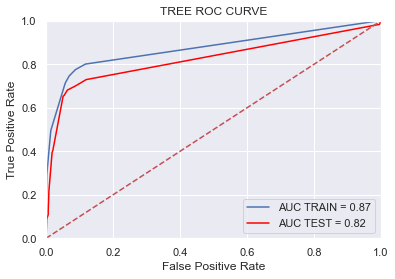

In [226]:
plt.title('TREE ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [227]:
feature_cols = list( X.columns.values )
tree.export_graphviz(fm01_Tree,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )
vars_tree_flag = getTreeVars( fm01_Tree, feature_cols ) 

In [228]:
for i in vars_tree_flag:
    print(i)

LOAN
JOB_Office
JOB_Sales
IMP_MORTDUE
M_VALUE
IMP_VALUE
M_YOJ
IMP_YOJ
M_DEROG
IMP_DEROG
IMP_DELINQ
IMP_CLAGE
M_DEBTINC
IMP_DEBTINC


### Decision Trees to predict the loss amount assuming that the loan defaults

In [232]:
amt_m01_Tree = tree.DecisionTreeRegressor( max_depth= 4 )
amt_m01_Tree = amt_m01_Tree.fit( W_train, Z_train["TARGET_LOSS_AMT"] )
Z_Pred_train = amt_m01_Tree.predict(W_train)
Z_Pred_test = amt_m01_Tree.predict(W_test)

print( "MEAN Train", Z_train["TARGET_LOSS_AMT"].mean() )
print( "MEAN Test", Z_test["TARGET_LOSS_AMT"].mean() )
print( " ----- \n\n" )

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train["TARGET_LOSS_AMT"], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test["TARGET_LOSS_AMT"], Z_Pred_test))
print("TREE RMSE Train:", RMSE_TRAIN )
print("TREE RMSE Test:", RMSE_TEST )

RMSE_TREE = RMSE_TEST
feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( amt_m01_Tree, feature_cols ) 
tree.export_graphviz(amt_m01_Tree,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )
print("\n")

for i in vars_tree_amt :    
    print(i)
    
##print( "FLAG=",vars_tree_flag )
##print(" ==== \n\n")

MEAN Train 12163.315621679065
MEAN Test 11946.959677419354
 ----- 


TREE RMSE Train: 3216.216446881694
TREE RMSE Test: 3942.9974837311943


LOAN
IMP_MORTDUE
IMP_CLNO
M_DEBTINC
IMP_DEBTINC


### Random Forests to predict the probability of default

In [233]:
def getEnsembleTreeVars( ENSTREE, varNames ) :    
    importance = ENSTREE.feature_importances_    
    index = np.argsort(importance)    
    theList = []    
    for i in index :        
        imp_val = importance[i]        
        if imp_val > np.average( ENSTREE.feature_importances_ ) :            
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )            
            theList.append( ( varNames[i], v ) )    
    theList = sorted(theList,key=itemgetter(1),reverse=True)    
    return theList

In [234]:
fm01_RF = RandomForestClassifier( n_estimators = 25, random_state=1 )
fm01_RF = fm01_RF.fit( X_train, Y_train[ "TARGET_BAD_FLAG" ] )

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

In [235]:
print("\n=============\n")
print("RANDOM FOREST\n")
print("Probability of Bad Loan Flag")
print("Accuracy Train:",metrics.accuracy_score(Y_train["TARGET_BAD_FLAG"], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test["TARGET_BAD_FLAG"], Y_Pred_test))
print("\n")



RANDOM FOREST

Probability of Bad Loan Flag
Accuracy Train: 0.9993708053691275
Accuracy Test: 0.9119127516778524




In [236]:
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train["TARGET_BAD_FLAG"], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_RF.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test["TARGET_BAD_FLAG"], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test
feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( fm01_RF, feature_cols )

('M_DEBTINC', 100)
('IMP_DEBTINC', 73)
('IMP_CLAGE', 45)
('IMP_DELINQ', 41)
('LOAN', 40)
('IMP_VALUE', 38)
('IMP_CLNO', 37)
('IMP_MORTDUE', 36)
('IMP_YOJ', 28)
('IMP_DEROG', 24)
('IMP_NINQ', 21)


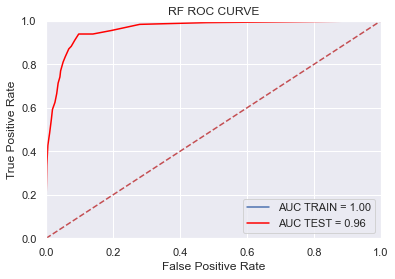

In [237]:
for i in vars_RF_flag :
    print( i )
    
plt.title('RF ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest to predict the loss amount assuming that the loan defaults

In [238]:
amt_m01_RF = RandomForestRegressor(n_estimators = 100, random_state=1)
amt_m01_RF = amt_m01_RF.fit( W_train, Z_train["TARGET_LOSS_AMT"] )
Z_Pred_train = amt_m01_RF.predict(W_train)
Z_Pred_test = amt_m01_RF.predict(W_test)

print( "MEAN Train", Z_train["TARGET_LOSS_AMT"].mean() )
print( "MEAN Test", Z_test["TARGET_LOSS_AMT"].mean() )
print( " ----- \n\n" )

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train["TARGET_LOSS_AMT"], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test["TARGET_LOSS_AMT"], Z_Pred_test))
print("RF RMSE Train:", RMSE_TRAIN )
print("RF RMSE Test:", RMSE_TEST )

RMSE_RF = RMSE_TEST
feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( amt_m01_RF, feature_cols )

for i in vars_RF_amt :
    print( i )

MEAN Train 12163.315621679065
MEAN Test 11946.959677419354
 ----- 


RF RMSE Train: 823.4883298593605
RF RMSE Test: 2178.544160557225
('LOAN', 100)
('IMP_CLNO', 13)
('IMP_DEBTINC', 10)


### Gradient Boosting model to predict the probability of default

In [188]:
fm01_GB = GradientBoostingClassifier( random_state=1 )
fm01_GB = fm01_GB.fit( X_train, Y_train["TARGET_BAD_FLAG"] )
Y_Pred_train = fm01_GB.predict(X_train)
Y_Pred_test = fm01_GB.predict(X_test)
print("\n=============\n")
print("GRADIENT BOOSTING\n")
print("Probability of bad loan")

print("Accuracy Train:",metrics.accuracy_score(Y_train["TARGET_BAD_FLAG"], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test["TARGET_BAD_FLAG"], Y_Pred_test))
print("\n")



GRADIENT BOOSTING

Probability of bad loan
Accuracy Train: 0.9230285234899329
Accuracy Test: 0.9010067114093959




In [189]:
probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train["TARGET_BAD_FLAG"], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test["TARGET_BAD_FLAG"], p1)

roc_auc_test = metrics.auc(fpr_test, tpr_test)
fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test
feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( fm01_GB, feature_cols )

('M_DEBTINC', 100)
('IMP_DEBTINC', 29)
('IMP_DELINQ', 19)
('IMP_CLAGE', 14)
('IMP_DEROG', 7)


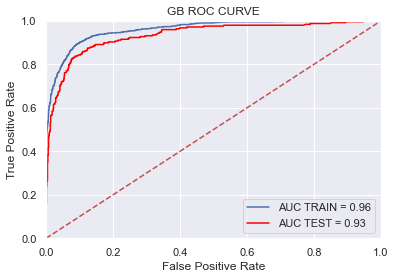

In [190]:
for i in vars_GB_flag :
    print(i)

plt.title('GB ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gradient Boosting to predict the loss amount assuming that the loan defaults

In [241]:
amt_m01_GB = GradientBoostingRegressor(random_state=1)
amt_m01_GB = amt_m01_GB.fit( W_train, Z_train["TARGET_LOSS_AMT"] )
Z_Pred_train = amt_m01_GB.predict(W_train)
Z_Pred_test = amt_m01_GB.predict(W_test)

print( "MEAN Train", Z_train["TARGET_LOSS_AMT"].mean() )
print( "MEAN Test", Z_test["TARGET_LOSS_AMT"].mean() )
print( " ----- \n\n" )

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train["TARGET_LOSS_AMT"], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test["TARGET_LOSS_AMT"], Z_Pred_test))
print("GB RMSE Train:", RMSE_TRAIN )
print("GB RMSE Test:", RMSE_TEST )
RMSE_GB = RMSE_TEST

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( amt_m01_GB, feature_cols )

for i in vars_GB_amt :
    print( i )

MEAN Train 12163.315621679065
MEAN Test 11946.959677419354
 ----- 


GB RMSE Train: 1046.8184939110056
GB RMSE Test: 1833.6964090936965
('LOAN', 100)
('IMP_CLNO', 16)
('IMP_DEBTINC', 8)
('M_DEBTINC', 7)


### Model Comparison

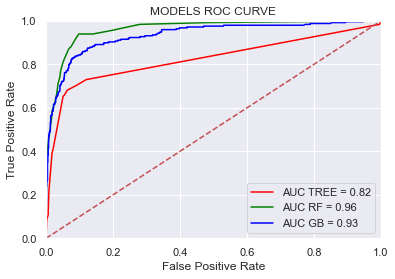

Root Mean Square Average For Loss Amount
TREE 5732.6842719501765
RF 3203.798055210686
GB 2641.9375614891906


In [192]:
plt.title('MODELS ROC CURVE')
plt.plot(fpr_tree, tpr_tree, 'b', label = 'AUC TREE = %0.2f' % auc_tree, color="red")
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC RF = %0.2f' % auc_RF, color="green")
plt.plot(fpr_GB, tpr_GB, 'b', label = 'AUC GB = %0.2f' % auc_GB, color="blue")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("Root Mean Square Average For Loss Amount")
print("TREE", RMSE_TREE)
print("RF", RMSE_RF)
print("GB", RMSE_GB)